# **Assignment 5. Residual Network**

* 看懂Residual Network樣板程式，解析其網路結構。
* 基於樣板設計一個Residual Network, 與作業四VGG模型進行分析與比較(那個模型較好，為什麼?)。
* (Optional)比較多個不同深度Residual Networks (以Residual Block為單位)，檢視”Deeper is Better”是否成立。

In [1]:
# Import
import os, torch
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#from google.colab import drive
from keras.datasets import cifar10
from tensorflow.keras import regularizers, initializers, optimizers, metrics, utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Add, AveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set Direction
drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/My Drive/data/tmp/Introduction-to-Machine-Learning/homework/HW5')
os.chdir('/content/gdrive/My Drive/data/HW5')

Mounted at /content/gdrive


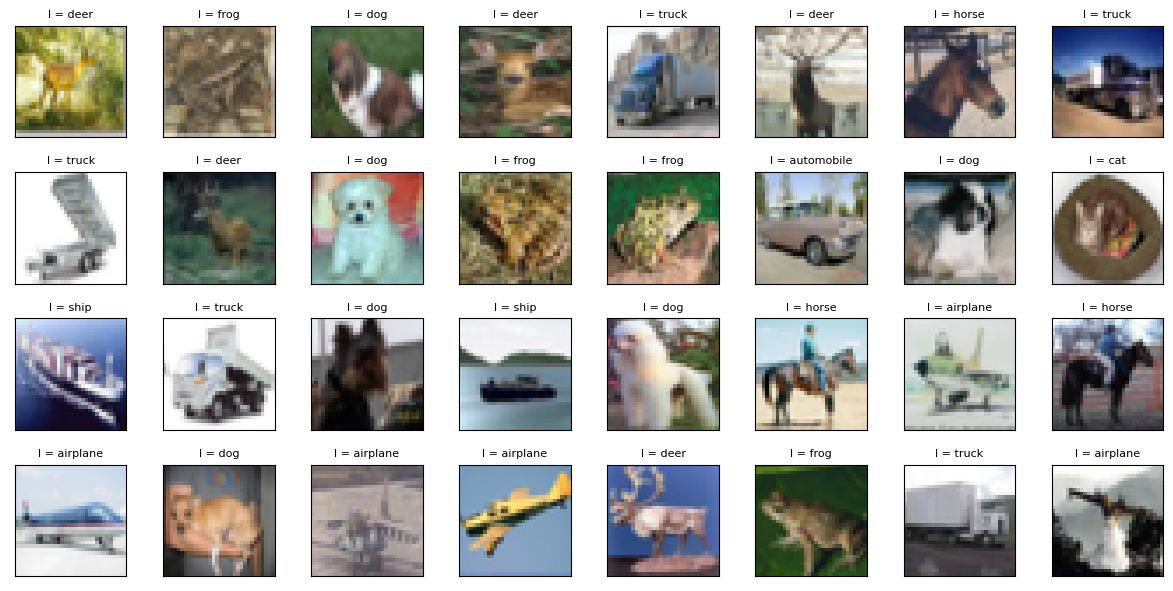

In [4]:
# Loading the CIFAR-10 Dataset
(x_train_image, y_train_label), (x_test_image, y_test_label) = cifar10.load_data()

# Declare Variables
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_multiimages(images, labels, prediction, idx, num=32):
    fig, ax = plt.subplots(4, 8, figsize=(12, 6))
    if num > 32: num = 32
    for i in range(0, num):
        ax = plt.subplot(4,8, 1+i)
        ax.imshow(images[idx])
        title = "l = " + class_names[int(labels[idx])]
        if len(prediction) > 0:
            title = "l = {}, p = {}".format(class_names[int(labels[idx])], class_names[prediction[idx]])
        else:
            title = "l = {}".format(class_names[int(labels[idx])])
        ax.set_title(title, fontsize=8)
        ax.set_xticks([]); ax.set_yticks([])
        idx+=1
    plt.tight_layout()
    plt.show()

plot_multiimages(x_test_image, y_test_label, [], 500, 32)

# Convert and Pre-Processing
x_train = x_train_image.reshape(len(x_train_image), 32, 32, 3).astype('float32')
x_test = x_test_image.reshape(len(x_test_image), 32, 32, 3).astype('float32')
x_train_norm = x_train / 255
x_test_norm = x_test / 255
y_TrainOneHot = utils.to_categorical(y_train_label)
y_TestOneHot = utils.to_categorical(y_test_label)

In [4]:
# Build a ResNet
def identity_block(X, filters):
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the Input Value
    X_shortcut = X

    # First Component of Main Path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second Component of Main Path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third Component of Main Path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)

    # Final Step: Add Shortcut Value to Main Path, and Pass It Through a RELU Activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, filters):
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the Input Value
    X_shortcut = X

    ##### MAIN PATH #####
    # First Component of Main Path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second Component of Main Path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third Component of Main Path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(2, 2), padding='same')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Final Step: Add Shortcut Value to Main Path, and Pass It Through a RELU Activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResidualNetwork(input_shape=(32, 32, 3), classes=10):
    # Define the Input As a Tensor with Shape Input_Shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (3, 3), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Stage 2
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])
    X = identity_block(X, [16, 16, 64])

    # Stage 3
    X = convolutional_block(X, filters=[32, 32, 128])
    X = identity_block(X, [32, 32, 128])
    X = identity_block(X, [32, 32, 128])
    X = identity_block(X, [32, 32, 128])

    # Stage 4
    X = convolutional_block(X, filters=[64, 64, 256])
    X = convolutional_block(X, filters=[64, 64, 256])

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output Layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create Model
    ResNet_model = Model(inputs=X_input, outputs=X)
    
    return ResNet_model

ResNet = ResidualNetwork(input_shape = (32, 32, 3), classes = 10)

# Summary
ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [5]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 80:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)    

In [6]:
# Train ResNet Model
ResNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
img_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, horizontal_flip=True, zoom_range=0r)
img_gen.fit(x_train_norm)
train_history = ResNet.fit(img_gen.flow(x_train_norm, y_TrainOneHot, batch_size=16), steps_per_epoch=1500, epochs=150, callbacks=[callback], shuffle=True, validation_data = (x_test_norm, y_TestOneHot), verbose=1)

Epoch 1/150
1500/1500 [==============================] - 51s 26ms/step - loss: 1.7960 - accuracy: 0.3433 - val_loss: 1.5497 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 2/150
1500/1500 [==============================] - 37s 24ms/step - loss: 1.4558 - accuracy: 0.4734 - val_loss: 1.7673 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 3/150
1500/1500 [==============================] - 38s 26ms/step - loss: 1.2805 - accuracy: 0.5406 - val_loss: 1.5492 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 4/150
1500/1500 [==============================] - 38s 25ms/step - loss: 1.1372 - accuracy: 0.5945 - val_loss: 1.1475 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 5/150
1500/1500 [==============================] - 37s 25ms/step - loss: 1.0345 - accuracy: 0.6288 - val_loss: 1.1714 - val_accuracy: 0.5930 - lr: 0.0010
Epoch 6/150
1500/1500 [==============================] - 37s 25ms/step - loss: 0.9460 - accuracy: 0.6668 - val_loss: 0.9106 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 7/150
1500/1500 [=================

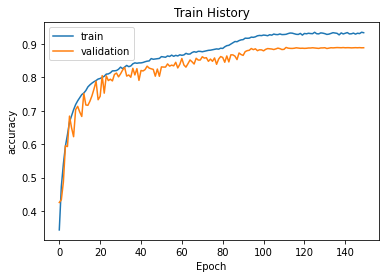

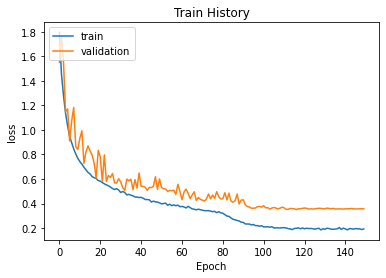

In [7]:
# Show Train History
def show_train_history(train_history, train, validation, filename):  
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')  
    plt.xlabel('Epoch') 
    plt.ylabel(train)  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.savefig(filename)
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy', './picture/train_history1_accuracy.png')
show_train_history(train_history, 'loss', 'val_loss', './picture/train_history1_loss.png')

In [8]:
# Save Model
ResNet.save('./model1_ResNet.h5') 

In [5]:
# Load Model
ResNet = load_model('./model1_ResNet.h5')

In [7]:
# Score
scores = ResNet.evaluate(x_test_norm, y_TestOneHot)
print()
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))
print("\t[Info]   Loss   of testing data = {:0.4f}".format(scores[0]))

313/313 [==============================] - 53s 170ms/step - loss: 0.3574 - accuracy: 0.8890

	[Info] Accuracy of testing data = 88.9%
	[Info]   Loss   of testing data = 0.3574
